This kernel is inspired by [@Branden Murray](https://www.kaggle.com/brandenkmurray)'s thoughts about [Any explanation why shuffling augmentation works?](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/84847). I quote his hypothesis:

>Well, one explanation could be that it's how they generated the dataset in the first place. For each feature they had a distribution for target==0 and a distribution for target==1 and they randomly sampled from each and then put it together.

I'm going to generate positive(target==1) and negative(target==0) samples for each feature, then combine the 200 simulated features together, I can get a synthetic data. With this simulated data, I can test Brander Murray's hypothesis.  

If his hypothesis is true, then we can calculate the probability of positive sample(i.e. P(target=1|features)) using traditional Probability theory.

In [1]:
import numpy as np 
import pandas as pd
import lightgbm as lgb
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('../input/train.csv', index_col=0)
test = pd.read_csv('../input/test.csv', index_col=0)

target = train.target.values
train.drop('target', axis=1, inplace=True)
train.shape, target.shape, test.shape, 

((200000, 200), (200000,), (200000, 200))

### Calculate the mean/sd of postive and negative samples for each feature

In [3]:
pos_idx = (target == 1)
neg_idx = (target == 0)
stats = []
for col in train.columns:
    stats.append([
        train.loc[pos_idx, col].mean(),
        train.loc[pos_idx, col].std(),
        train.loc[neg_idx, col].mean(),
        train.loc[neg_idx, col].std()
    ])
    
stats_df = pd.DataFrame(stats, columns=['pos_mean', 'pos_sd', 'neg_mean', 'neg_sd'])
stats_df.head()

,pos_mean,pos_sd,neg_mean,neg_sd
0,11.156418,3.270293,10.626681,3.008564
1,-1.017613,4.220638,-1.695770,4.024813
2,11.156633,2.841075,10.665876,2.612961
3,6.864113,2.070898,6.788979,2.040082
4,11.131337,1.649266,11.072412,1.620103


### Synthetic data using normal distribution with train's mean/sd

In [4]:
npos = pos_idx.sum()
nneg = neg_idx.sum()

sim_feats = []
for pos_mean, pos_sd, neg_mean, neg_sd in stats:
    pos_feat = np.random.normal(loc=pos_mean, scale=pos_sd, size=npos)
    neg_feat = np.random.normal(loc=neg_mean, scale=neg_sd, size=nneg)
    sim_feats.append(np.hstack([pos_feat, neg_feat]))
    
sim_feats = np.column_stack(sim_feats)
sim_target = np.hstack([np.ones(npos), np.zeros(nneg)])

In [5]:
sim_feats.shape, sim_target.shape

((200000, 200), (200000,))

### Test the synthetic data

In [6]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [7]:
trn_data = lgb.Dataset(sim_feats, sim_target)
cv = lgb.cv(param, trn_data, 100000, shuffle=True, early_stopping_rounds=600, verbose_eval=600)
print(cv['auc-mean'][-1], len(cv['auc-mean']))

[600]	cv_agg's auc: 0.859474 + 0.00283987
[1200]	cv_agg's auc: 0.868508 + 0.00352786
[1800]	cv_agg's auc: 0.872842 + 0.00311873
[2400]	cv_agg's auc: 0.876242 + 0.00308192
[3000]	cv_agg's auc: 0.878284 + 0.00301556
[3600]	cv_agg's auc: 0.880043 + 0.00297988
[4200]	cv_agg's auc: 0.881187 + 0.00291464
[4800]	cv_agg's auc: 0.882087 + 0.00297438
[5400]	cv_agg's auc: 0.882716 + 0.00299189
[6000]	cv_agg's auc: 0.883233 + 0.00290837
[6600]	cv_agg's auc: 0.88369 + 0.00287925
[7200]	cv_agg's auc: 0.883943 + 0.00283904
[7800]	cv_agg's auc: 0.884205 + 0.00284252
[8400]	cv_agg's auc: 0.884384 + 0.00281212
[9000]	cv_agg's auc: 0.884479 + 0.00284024
[9600]	cv_agg's auc: 0.884507 + 0.00288774
[10200]	cv_agg's auc: 0.884588 + 0.00286203
[10800]	cv_agg's auc: 0.88457 + 0.00281234
0.8845980663774207 10564


We can achieve 0.885 just using train data's mean and sd, this is not bad! Maybe the data is generated using this way!

### Calculate probability use hypothetical test

If each feature is generated by sample positive samples and negtive samples, then we can use hypothetical test to distinguish them. The positive samples and negative samples of each feature are slightly different. Let's take `var_0` and `var_1` as an example. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'var_1')

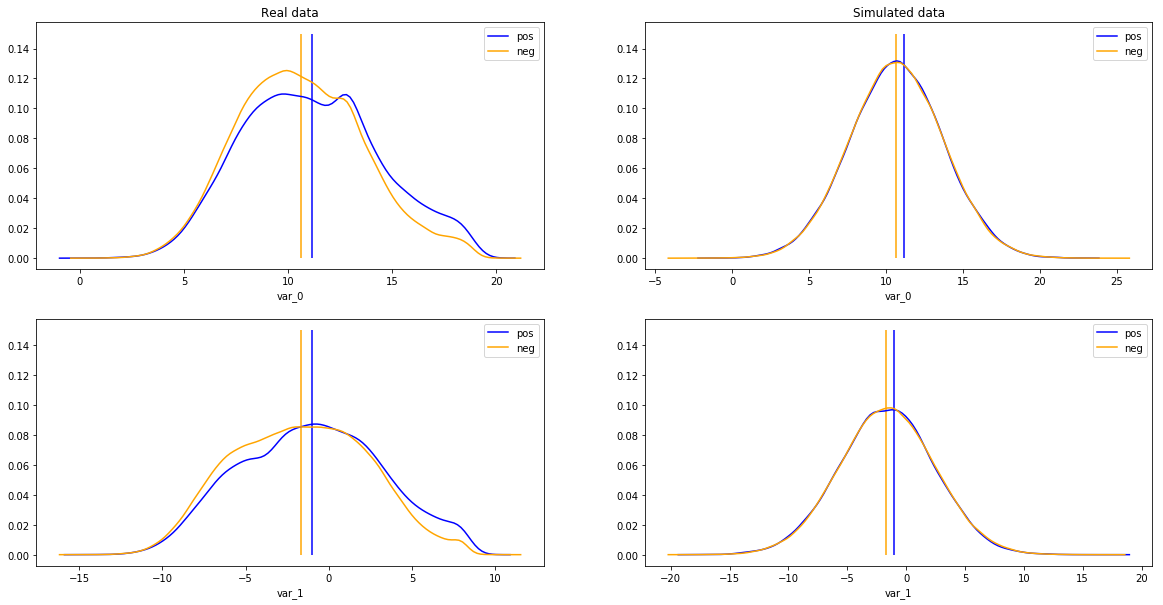

In [8]:
plt.figure(figsize=(20, 10))
# var_0
plt.subplot(2, 2, 1)
sns.distplot(train.loc[pos_idx, 'var_0'], hist=False, label='pos', color='blue')
sns.distplot(train.loc[neg_idx, 'var_0'], hist=False, label='neg', color='orange')
plt.vlines(x=[stats_df.loc[0, 'pos_mean'], stats_df.loc[0, 'neg_mean']], ymin=0, ymax=0.15, colors=['blue', 'orange'])
plt.xlabel('var_0')
plt.title('Real data')
plt.legend()
plt.subplot(2, 2, 2)
sns.distplot(sim_feats[pos_idx, 0], hist=False, label='pos', color='blue')
sns.distplot(sim_feats[neg_idx, 0], hist=False, label='neg', color='orange')
plt.vlines(x=[stats_df.loc[0, 'pos_mean'], stats_df.loc[0, 'neg_mean']], ymin=0, ymax=0.15, colors=['blue', 'orange'])
plt.title('Simulated data')
plt.legend()
plt.xlabel('var_0')

# var_1
plt.subplot(2, 2, 3)
sns.distplot(train.loc[pos_idx, 'var_1'], hist=False, label='pos', color='blue')
sns.distplot(train.loc[neg_idx, 'var_1'], hist=False, label='neg', color='orange')
plt.vlines(x=[stats_df.loc[1, 'pos_mean'], stats_df.loc[1, 'neg_mean']], ymin=0, ymax=0.15, colors=['blue', 'orange'])
plt.xlabel('var_1')
plt.legend()
plt.subplot(2, 2, 4)
sns.distplot(sim_feats[pos_idx, 1], hist=False, label='pos', color='blue')
sns.distplot(sim_feats[neg_idx, 1], hist=False, label='neg', color='orange')
plt.vlines(x=[stats_df.loc[1, 'pos_mean'], stats_df.loc[1, 'neg_mean']], ymin=0, ymax=0.15, colors=['blue', 'orange'])
plt.legend()
plt.xlabel('var_1')

Let's use Z-test:
- Null hypothesis: a sample is negative(target == 0)
- Alternative hypothesis: a sample is not negative(target == 1)

If we get a small pvalue(< 0.05), we reject the null hypothesis, i.e. the smaller the pvalue, the more likely a sample is positive.

In [9]:
zval1 = (train.values - stats_df.neg_mean.values) / stats_df.neg_sd.values
zval1.shape

(200000, 200)

In [10]:
pval1 = (1 - norm.cdf(np.abs(zval1))) * 2

In [11]:
pval1

array([[0.57177027, 0.20594774, 0.63449577, ..., 0.69837486, 0.29121058,
        0.82376126],
       [0.77145121, 0.54245537, 0.22172421, ..., 0.88720733, 0.41422096,
        0.60700232],
       [0.50250964, 0.79419708, 0.58824061, ..., 0.47761577, 0.68657618,
        0.71488458],
       ...,
       [0.84283093, 0.40437388, 0.95325361, ..., 0.82443714, 0.48263242,
        0.4655326 ],
       [0.76181736, 0.08582372, 0.25978831, ..., 0.2241812 , 0.8944557 ,
        0.31498317],
       [0.93390222, 0.31852433, 0.57831086, ..., 0.42411589, 0.2025446 ,
        0.73342109]])

Since we have 200 feats, we get 200 pvalue for each sample, we can multiply them together.

In [12]:
prob1 = pval1.prod(axis=1)

The smaller the prob1, the more likely a sample is positive. let's see the performance.

In [13]:
roc_auc_score(target, 1/prob1)

0.7195175007871486

If we test whether a sample is positive, we can get another hypothetical test:
- Null hypothesis: a sample is positive(target == 1)
- Alternative hypothesis: a sample is not positive(target == 0)

If we get a small pvalue(< 0.05), we reject the null hypothesis, i.e. the bigger the pvalue, the more likely a sample is positive.

In [14]:
zval2 = (train.values - stats_df.pos_mean.values) / stats_df.pos_sd.values
pval2 = (1 - norm.cdf(np.abs(zval2))) * 2

In [15]:
prob2 = pval2.prod(axis=1)

Combine the two prob together:

In [16]:
roc_auc_score(target, prob2 / prob1)

0.8740511207814198

**We can get 0.874 just using Probability theory, It's quite good I think.**

 ### Use this mothed to predict test.csv

In [17]:
te_zval1 = (test.values - stats_df.neg_mean.values) / stats_df.neg_sd.values
te_pval1 = (1 - norm.cdf(np.abs(te_zval1))) * 2
te_prob1 = te_pval1.prod(axis=1)

In [18]:
te_zval2 = (test.values - stats_df.pos_mean.values) / stats_df.pos_sd.values
te_pval2 = (1 - norm.cdf(np.abs(te_zval2))) * 2
te_prob2 = te_pval2.prod(axis=1)

In [19]:
pred = te_prob2 / te_prob1

In [20]:
pd.DataFrame({
    'ID_code': test.index,
    'target': pred
}).to_csv('sub.csv', index=False)

### Conclusion

Branden Murray's hypothesis **For each feature they had a distribution for target==0 and a distribution for target==1 and they randomly sampled from each and then put it together** is a wonderful explanation of shuffling also works and weak interaction between features.

We can even use tranditional Probability theory to calculate the P(target==1) value to achive 0.874 local cv. But this model is still too naive, the feature is not normal distribution(I try normality test, none of the 200 features passed), and the positive samples and negative samples is not variance homogeneity(2/3 of the features failed variance homogeneity test).

Hope this kernal can help, thanks!